# 🌿 OSCAR from a Jupyter Notebook: Asynchronous Service  

In this example, you will learn how to **call an asynchronous service** and retrieve its output from **MinIO storage**. 📂  

🔹 Since this is an **asynchronous service**, the response will not be immediate. Instead, the processed output will be stored in MinIO.  

## 🛠️ Service Definition  

To create an [OSCAR service](https://docs.oscar.grycap.net/#concepts) on the cluster, we need to define its configuration using a **YAML** file in **FDL** format.  

We also need:  
📌  🐳 A **Docker image** that includes the application (e.g. a pre-trained AI model) and all the required libraries and data to perform its execution.  
📌 📜 A **shell-script** to be executed inside the container created out of the Docker image for each service invocation.   

📖 Learn more about **FDL** in the [OSCAR documentation](https://docs.oscar.grycap.net/fdl/).  
🎨 For an easier graphical configuration, check out the **[FDL Composer](https://docs.oscar.grycap.net/fdl-composer/)**.    

### 🌱 Plant Classification  

This time for demonstration, we will use an **asynchronous** service that automatically detects and classifies plants from images. It receives an image and returns it after processing.

📥 **INPUT** → Stored in **MinIO**:

![image](img/plant-input.jpg)  

📤 **OUTPUT** → Saved in **MinIO** or another storage:

![image](img/plant-output.jpg)   

#### 📜 FDL Definition  

To define a **basic FDL configuration file**, like in the synchronous services, we need to specify:  

📌 **Service Name** → The unique name of the service. 🏷️  
📌 **CPU Cores (`cpu`)** → The number of cores required for execution. ⚡  
📌 **Memory (`memory`)** → The amount of RAM needed (in **Mi** or **Gi**). 💾  
📌 **Docker Image (`image`)** → The container image essential for the service. 🐳  
📌 **Execution Script (`script`)** → The script that will run inside the instance. 📜  

Since this service is **asynchronous**, we also need to specify:

📌 **Input Storage (`input`)** 📂 → Triggers the execution  
📌 **Output Storage (`output`)** 📂 → Stores the processed results  

🔹 Unlike the synchronous services, we **do not need** to set the log level to **critical** because we won’t receive the response directly.


## ⚙️ Service Creation  

After setting up the environment and defining our services, we can now **deploy** them on our **OSCAR cluster**. 🚀  

### 📚 Import Libraries  

To interact with **OSCAR** from a **Jupyter Notebook**, we will use the **[OSCAR Python client library](https://github.com/grycap/oscar_python)**. 

📖 Learn more about it on:  
🔹 [GitHub](https://github.com/grycap/oscar_python) 🛠️  
🔹 [PyPi](https://pypi.org/project/oscar-python/) 📦  

📌 Check the **OSCAR [OpenAPI documentation](https://docs.oscar.grycap.net/api/)** to understand the structure of the returned data. 

**_NOTE:_** This tutorial uses **version 1.3.0** of the Python library. 

In [7]:
from oscar_python.client import Client
from IPython.display import Image
import os

import urllib3
# Disable the SSL certificate verification warning to not distract us.
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

### 🔑 Create the Client with Credentials  

To interact with the **OSCAR cluster**, we must create a client instance and provide:  

🔹 **Cluster Identification Name (`cluster_id`)** → Used in the service configuration file to identify the cluster.  
🔹 **OSCAR Cluster Endpoint (`endpoint`)** → The environment variable is set to the current cluster where the notebook is created.  
🔹 **User Identification Tokens (`shortname`)** → Configured during environment setup with the default short name **"oscar-egi"**. 


In [8]:
options_oidc_auth = {'cluster_id': 'cluster-id',
                     'endpoint': os.environ["OSCAR_ENDPOINT"],
                     'shortname': 'oscar-egi',
                     'ssl': 'True'}

client = Client(options=options_oidc_auth)

### 📝 Declare Input Parameters  

We declare the **input parameters** as variables to ensure consistency and avoid errors when using them multiple times. 🔄

In [9]:
serviceName = "plant-classification-async-test"
storageProvider = "minio.default"
remoteInputPath = "plant-classification-async-test/input"
remoteOutputPath = "plant-classification-async-test/output"

inputImagePath = "img/plant-input.jpg"

### 🚀 Create Services  

To deploy services in the cluster, simply call the `create_service()` function and provide **service configuration file**:  

```python
    client.create_service("service_config.yaml")
```

In [10]:
try:
    client.create_service("plant-async.yaml")
    print("Service created")
except Exception as err:
    print("Failed with: ", err)

Failed with:  A service with name 'plant-classification-async-test' is already present on the cluster


#### 📋 Print the List of Available Services  

To check which services are currently deployed in the cluster, use the following command:  

```python
    client.list_services()
```
🔹 This function returns an HTTP response containing a JSON list of available services.

In [11]:
try:
    services = client.list_services()
    print("Services:")
    if services.status_code == 200:
        # Print the name of the services on the cluster
        for value in services.json():
            print("> " + value["name"])
        # You also can print the enite output in JSON format
        # json_object = json.loads(services.text)
        # json_formatted_str = json.dumps(json_object, indent=2)
        # print(json_formatted_str)
except Exception as err:
    print("Failed with: ", err)

Services:
> cowsay
> juno7e3b98
> plant-classification-async-test
> plants


## 🌿 Execute Plant Classification (Asynchronous)  

In order to execute an **asynchronous service**, we need to **connect to its storage** (defined in FDL) and **upload our input file** to the appropriate folder. 

1️⃣ To achieve that, we **create a storage client** using the `create_storage_client()` function, providing the **service name**:  

```python
    client.create_storage_client("service_name")
```

2️⃣ Once the storage client is created, we use the `upload_file()` function to save our input in the remote storage, providing the name of the **storage provider**, the local **input image path** and the **remote input path**:

```python
    storage_client.upload_file("storage_provider","input_image_path","remote_inpu_path")
```

In [36]:
try:
    storage_client = client.create_storage_client(serviceName) # returns a storage object
    response = storage_client.upload_file(storageProvider,
                                           inputImagePath,
                                           remoteInputPath)
    print("The input image has been sent")
except Exception as err:
    print("Failed with: ", err)

Uploading to bucket 'plant-classification-async-test' with key 'input'
The input image has been sent


#### 🔄 Alternative

As an alternative to the previously described method, you can use the `run_service()` function as in a synchronous service, providing the **service name**, **input file path**, and **indicating that it is an asynchronous** service:

```python
    client.run_service("service_name",input="input_image_path",async_call=True)
```

**_NOTE:_** If you call the service this way, the output image will be named as `event-file-xxxx...`

In [37]:
try:
    response = client.run_service(serviceName,
                                  input=inputImagePath,
                                  async_call=True)
    if services.status_code == 200:
        print("The input image has been sent")
except Exception as err:
    print("Failed with: ", err)

The input image has been sent


### ⏳ Check the Status  

Since the process is **asynchronous**, we can't be sure when it will finish. Therefore, we need to **request the list of jobs** run by the service and check their **status**. ✅  

To do this, we use the `list_jobs()` function, providing the **service name** we want to check:  

```python
    client.list_jobs("service_name")
```


In [41]:
try:
    log_list = client.list_jobs(serviceName) #Return HTTP response
    if log_list.status_code == 200:
        #Get JSON list from response
        json_log_list = log_list.json()
        #Go through all jobs
        for value in json_log_list:
            #Print job status
            print("Job:", value, ":\n", json_log_list[value], "\n")
except Exception as err:
    print("Failed with: ", err)

Job: plant-classifica-4f3a066e-948d-4607-9cb9-e8e53f5eb149 :
 {'status': 'Running', 'creation_time': '2025-03-07T12:43:49Z', 'start_time': '2025-03-07T12:43:51Z'} 

Job: plant-classifica-99e7eae3-e580-4e8a-9ecf-20ddc52e4d19 :
 {'status': 'Succeeded', 'creation_time': '2025-03-07T12:43:15Z', 'start_time': '2025-03-07T12:43:17Z', 'finish_time': '2025-03-07T12:44:31Z'} 

Job: plant-classifica-ac773a9e-aeee-480b-adf7-9e4eaabf0ee5 :
 {'status': 'Succeeded', 'creation_time': '2025-03-07T12:43:39Z', 'start_time': '2025-03-07T12:43:41Z', 'finish_time': '2025-03-07T12:44:41Z'} 



### 📂 Check the Remote Output Folder  

Once the execution is complete, we can check the **output folder** on the **remote storage** to retrieve the processed results. 🔍  

To do this, we use the `list_files_from_path()` function, providing the **storage provider** and the **remote output folder** (or any other remote folder you wish to consult).  

```python
    storage_client.list_files_from_path("storage_provider", "remote_output_path")
```

**_NOTE:_** Unlike the other requests we have seen, this one directly returns **JSON** as a response and not a HTTP.

In [43]:
try:
    storage_client = client.create_storage_client(serviceName)
    response = storage_client.list_files_from_path(storageProvider, #Return JSON response
                                                    remoteOutputPath)
    for value in response["Contents"]:
        print("> " + value["Key"])
except Exception as err:
    print("Failed with: ", err)

Reading content from path: plant-classification-async-test/output
> output/
> output/event-file-f4c3c8f1-012c-4b52-b7d8-2078954bc363.png
> output/plant-input.jpg


### ⬇️ Download the Output  

Once the output is available in the remote storage, we can **download the processed result** to our local machine. 📥  

To do this, we use the `download_file()` function, providing the **storage provider**, **remote file path**, and the **local foder path** where we want to save the file.  

```python
    storage_client.download_file("storage_provider", "local_folder_path or name", "remote_file_path")
```

📌 To execute the following cells, you need to wait until the status of the jog changes to `Succeeded`.


In [44]:
try:
    storage_client = client.create_storage_client(serviceName) # returns a storage object
    response = storage_client.download_file(storageProvider,
                                            "output",
                                            remoteOutputPath+"/plant-input.jpg")
    print("Output image downloaded")
except Exception as err:
    print("Failed with: ", err)

Output image downloaded


### 🖼️ Display Output Image  

Once the output file is downloaded, we can display the processed image directly in the notebook. 📸  

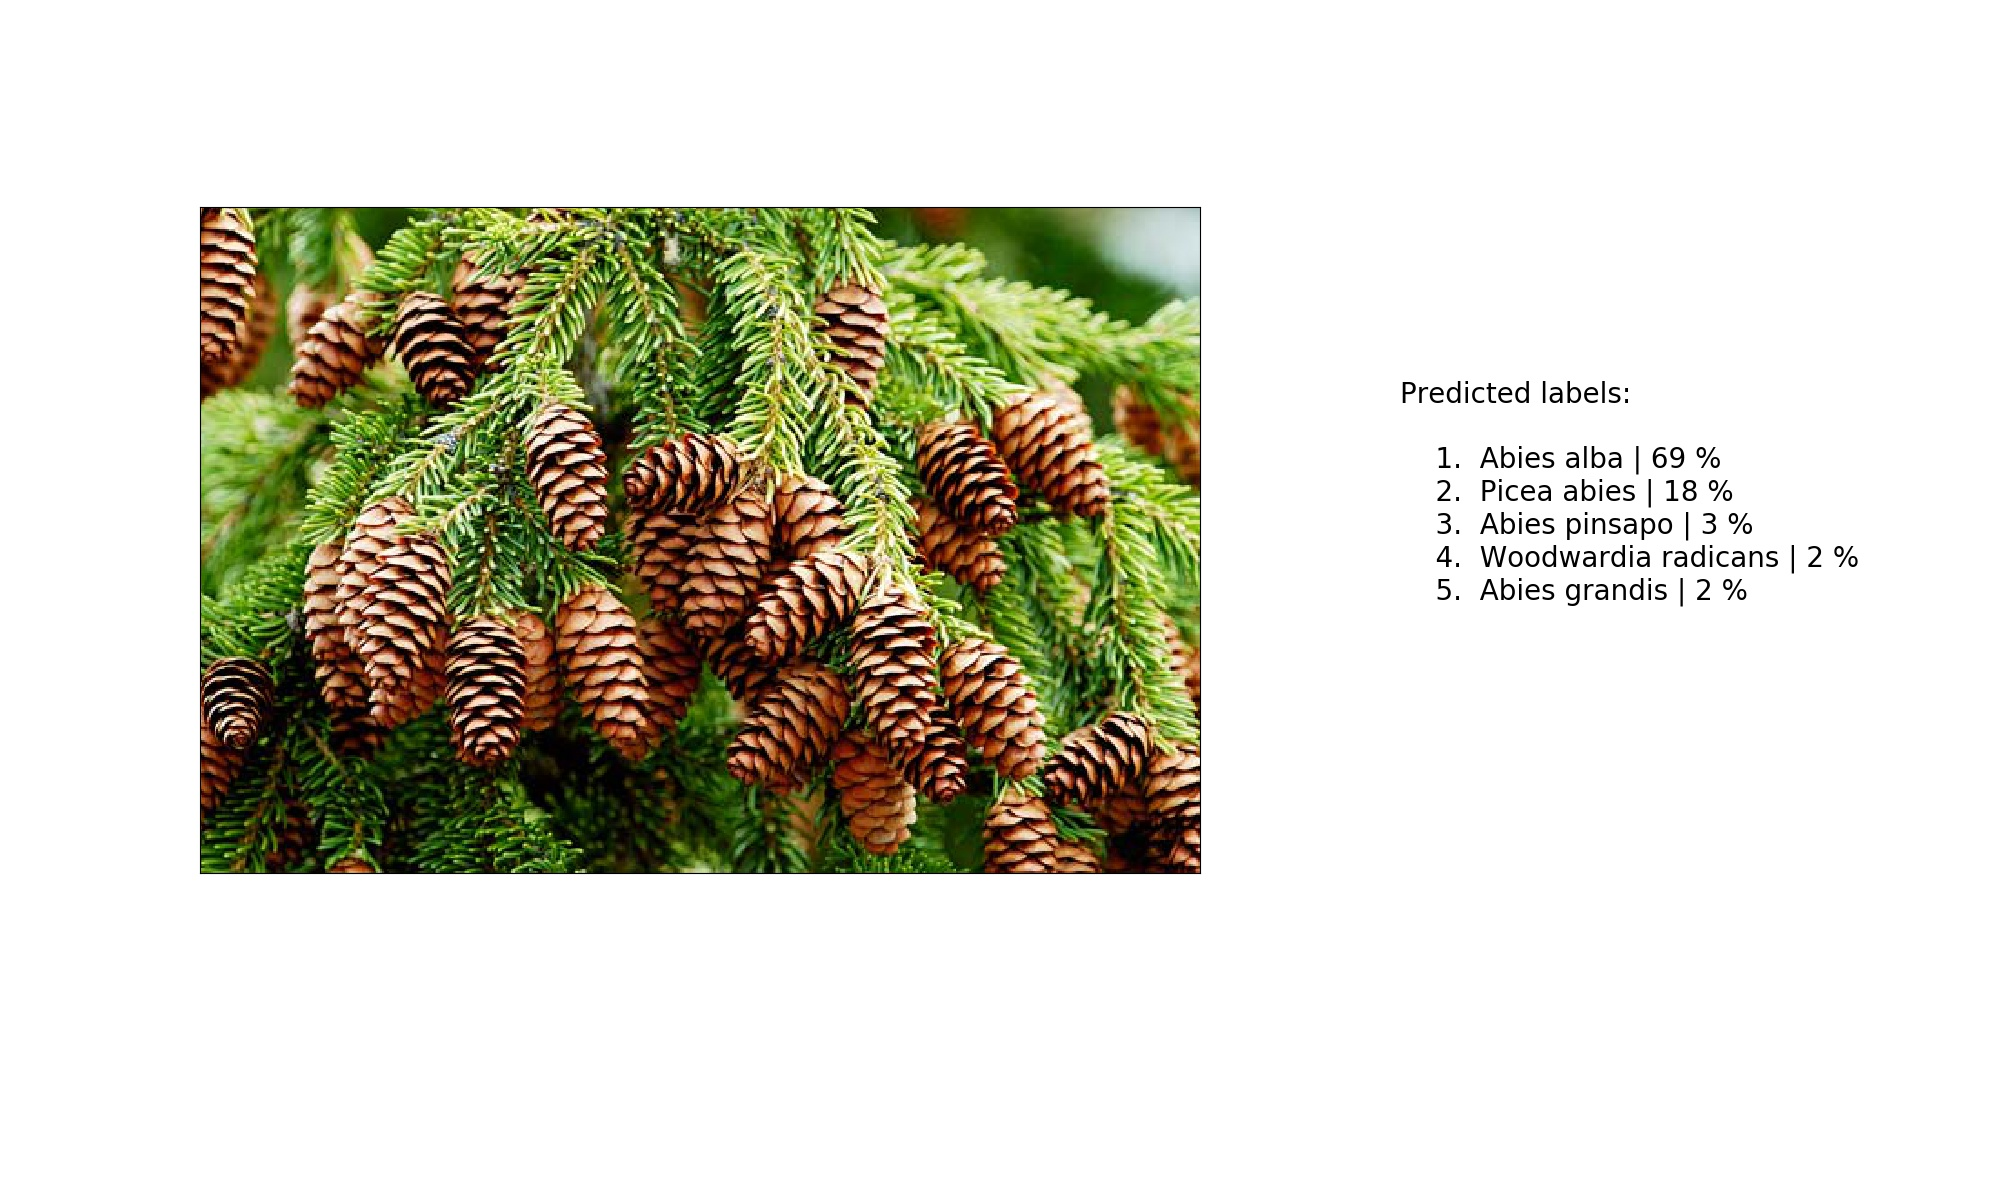

In [45]:
Image(filename='output/plant-input.jpg')

## 🗑️ Delete Services  

Finaley, to delete the services, we simply call the `remove_service()` function, providing the **service name**.  

```python
client.remove_service("service_name")
```

In [46]:
try:
    response = client.remove_service(serviceName)
    print("Service deleted")
except Exception as err:
    print("Failed with: ", err)

Service deleted
